In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import detrend

In [62]:
birth_df = pd.read_csv('Daily_Birth.csv')
birth_df

,Date,Num_Births
0,1977-01-01,208
1,1977-01-02,241
2,1977-01-03,274
3,1977-01-04,256
4,1977-01-05,294
...,...,...
5108,1990-12-27,316
5109,1990-12-28,335
5110,1990-12-29,237
5111,1990-12-30,229


In [63]:
birth_df['Date'] = pd.to_datetime(birth_df['Date'])
birth_df.dtypes

Date          datetime64[ns]
Num_Births             int64
dtype: object

In [64]:
birth_df.isna().value_counts()

Date   Num_Births
False  False         5113
Name: count, dtype: int64

In [65]:
birth_df['Month'] = birth_df['Date'].dt.month
birth_df['Year'] = birth_df['Date'].dt.year

birth_per_month = birth_df.groupby(['Year', 'Month'])['Num_Births'].sum().reset_index()
print(birth_per_month)

     Year  Month  Num_Births
0    1977      1        8000
1    1977      2        7446
2    1977      3        8682
3    1977      4        8477
4    1977      5        8683
..    ...    ...         ...
163  1990      8        8531
164  1990      9        8480
165  1990     10        8156
166  1990     11        7455
167  1990     12        7673

[168 rows x 3 columns]


In [66]:
birth_per_month['Date'] = pd.to_datetime(birth_per_month['Year'].astype(str) + '-' + birth_per_month['Month'].astype(str),
                                        format='%Y-%m')
birth_ts = pd.Series(birth_per_month['Num_Births'].values, index=birth_per_month['Date'])
birth_ts.index.freq = 'MS'

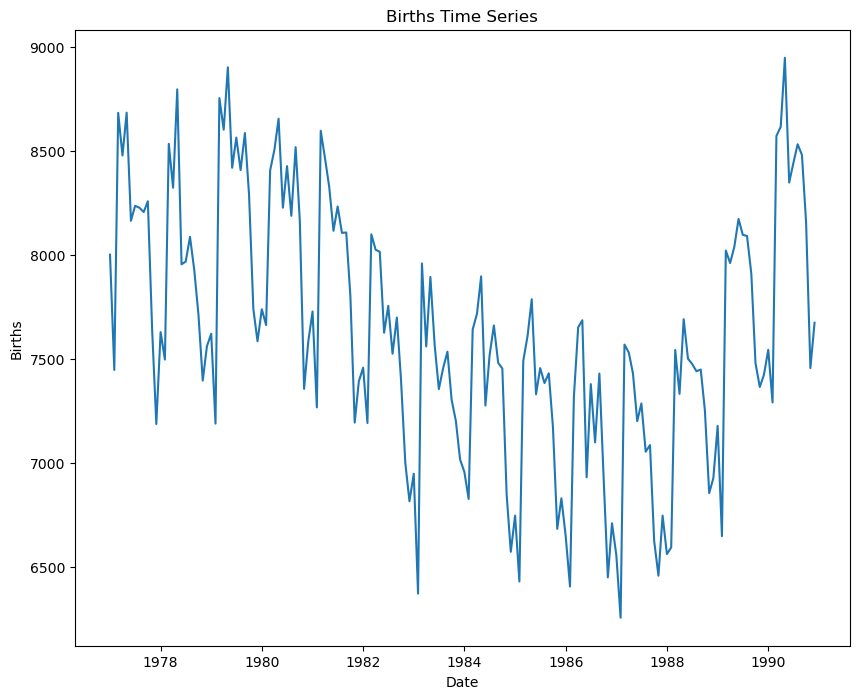

In [67]:
plt.figure(figsize=(10,8))
plt.plot(birth_ts)
plt.xlabel('Date')
plt.ylabel('Births')
plt.title('Births Time Series')
plt.show()

In [68]:
birth_df['Month'] = birth_df['Date'].dt.month
birth_df['Year'] = birth_df['Date'].dt.year

birth_per_year = birth_df.groupby(['Year'])['Num_Births'].mean().reset_index()
print(birth_per_year)

    Year  Num_Births
0   1977  266.298630
1   1978  261.295890
2   1979  270.263014
3   1980  266.177596
4   1981  261.156164
5   1982  248.219178
6   1983  241.517808
7   1984  239.997268
8   1985  236.547945
9   1986  231.873973
10  1987  229.564384
11  1988  236.644809
12  1989  253.076712
13  1990  268.624658


In [69]:
birth_year_ts = pd.Series(birth_per_year['Num_Births'].values, index=birth_per_year['Year'])
birth_year_ts.index.freq = 'YS'

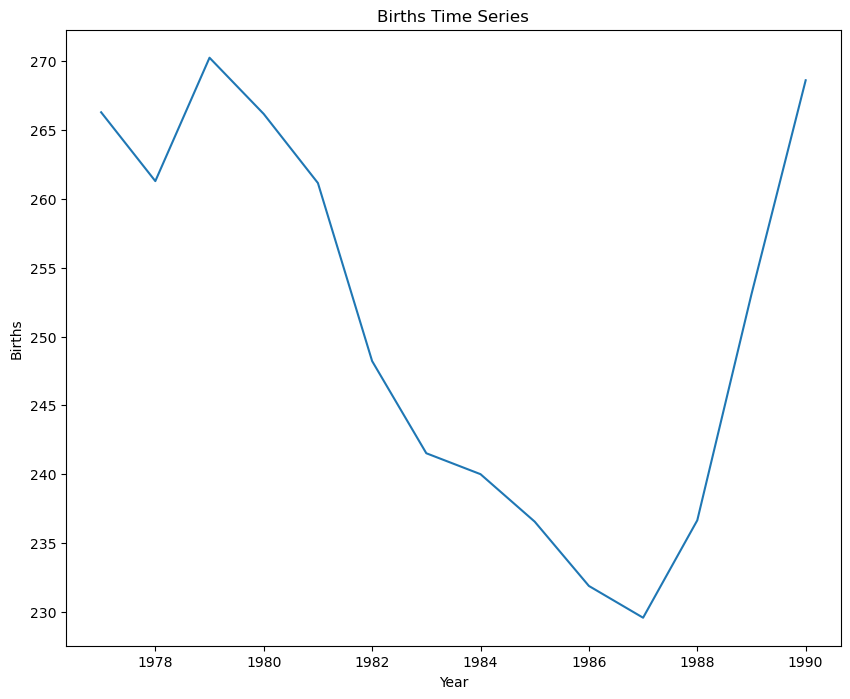

In [70]:
plt.figure(figsize=(10,8))
plt.plot(birth_year_ts)
plt.xlabel('Year')
plt.ylabel('Births')
plt.title('Births Time Series')
plt.show()

In [71]:
air_df = pd.read_csv('PRSA_Changping.csv')
air_df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,28.0,47.0,4.0,14.0,300.0,NaN,11.7,1008.9,-13.3,0.0,NNE,1.3,Changping
35060,35061,2017,2,28,20,12.0,12.0,3.0,23.0,500.0,64.0,10.9,1009.0,-14.0,0.0,N,2.1,Changping
35061,35062,2017,2,28,21,7.0,23.0,5.0,17.0,500.0,68.0,9.5,1009.4,-13.0,0.0,N,1.5,Changping
35062,35063,2017,2,28,22,11.0,20.0,3.0,15.0,500.0,72.0,7.8,1009.6,-12.6,0.0,NW,1.4,Changping


In [72]:
air_clean = air_df.dropna()

In [73]:
air_month = air_clean.groupby(['year', 'month'])['NO2'].sum().reset_index()

print(air_month.dtypes)

year       int64
month      int64
NO2      float64
dtype: object


In [74]:
air_month['Date'] = pd.to_datetime(air_month['year'].astype(str) + '-' + air_month['month'].astype(str),
                                        format='%Y-%m')
air_ts = pd.Series(air_month['NO2'].values, index=air_month['Date'])
air_ts.index.freq = 'MS'
air_ts

Date
2013-03-01    42031.0000
2013-04-01    24932.9939
2013-05-01    25057.0000
2013-06-01    10888.0000
2013-07-01    15497.0000
2013-08-01    17044.0000
2013-09-01    24177.0000
2013-10-01    33209.0000
2013-11-01    32135.0000
2013-12-01    36491.0000
2014-01-01    39019.0000
2014-02-01    35498.0000
2014-03-01    39294.0000
2014-04-01    31875.0000
2014-05-01    26694.5000
2014-06-01    21085.0000
2014-07-01    20858.0000
2014-08-01    26753.2000
2014-09-01    25176.8000
2014-10-01    38954.0000
2014-11-01    40282.2000
2014-12-01    34688.0000
2015-01-01    45719.2000
2015-02-01    28596.0000
2015-03-01    33638.5000
2015-04-01    25152.0000
2015-05-01    20002.0000
2015-06-01    16238.0000
2015-07-01    17217.0000
2015-08-01    16341.0000
2015-09-01    26174.0000
2015-10-01    26855.0000
2015-11-01    41528.0000
2015-12-01    54751.0000
2016-01-01    40601.0000
2016-02-01    29617.0000
2016-03-01    43116.0000
2016-04-01    30445.0000
2016-05-01    24855.0000
2016-06-01    22056.

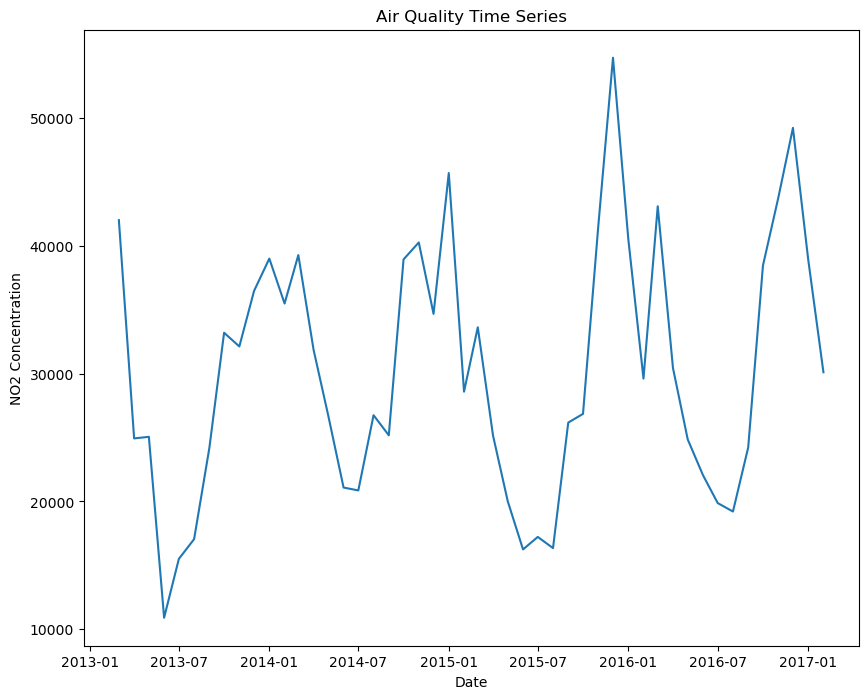

In [75]:
plt.figure(figsize=(10,8))
plt.plot(air_ts)
plt.xlabel('Date')
plt.ylabel('NO2 Concentration')
plt.title('Air Quality Time Series')
plt.show()

In [77]:
sm.stats.acorr_ljungbox(air_ts, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,90.283344,4.705886e-15


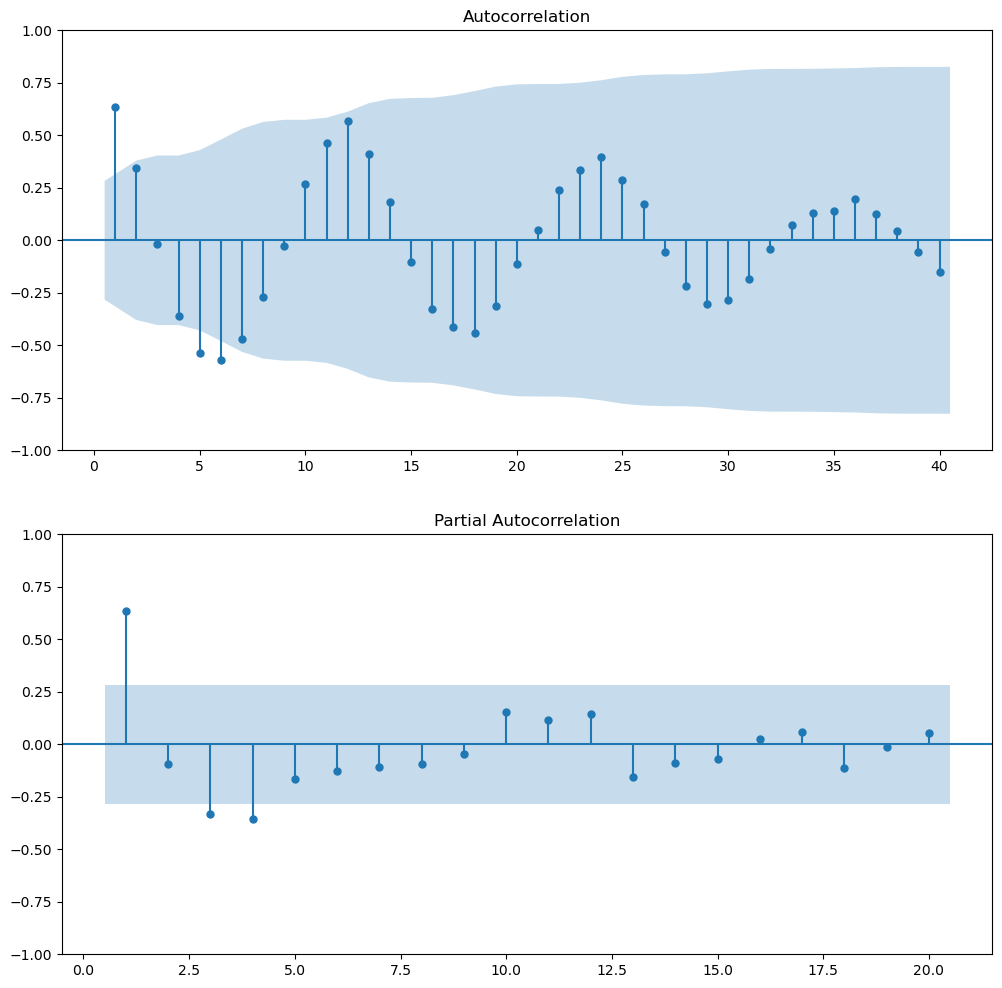

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

#Autocorrelation Plot using 40 time periods
plot_acf(air_ts, ax=ax1, zero=False, lags=40)

#Partial autocorrelation using 40 time periods
plot_pacf(air_ts, ax=ax2, zero=False, lags=20)
plt.show()


In [80]:
adfuller(air_ts, regression='c')

(-4.887437010428412,
 3.689214119997695e-05,
 5,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 760.6441408190611)